# Soil moisture distribution in an irrigation scheme

* **Products used:**
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)

## Background

Irrigation schemes are aged, and a lack of a proper water allocation plan results in an uneven distribution of soil moisture. Understanding the distribution of soil moisture within an irrigation scheme is crucial for efficient water management and maximizing crop yield. Digital Earth Africa (DEA) offers tools and applications for assessing soil moisture distributions in an irrigation scheme. In this exercise, the Meki-Ziway irrigation scheme blocks shapefile is available. Users should upload the shapefile to the training folder and use it as the sample scripts in this Jupyter Notebook.

## Description
This notebook demonstrates how to:

1. Import python pakages and functions
1. Import the Meki-Ziway irrigation scheme shapefile into the training folder
2. Import a time series cloud-free Sentinel-2 satellite imagery for the Meki-Ziway irrigation scheme
3. Plot the dataset using the true color composite over the Meki-Ziway irrigation scheme  
4. Rasterize the shapefile and mask it to the study region
5. Plot the data as a three band and single band time series animation for the Meki-Ziway irrigation scheme
6. Map soil moisture distribution in an irrigation scheme  

## Load packages

Loading relevant Python packages and supporting functions for the analysis is the first step.

* `%matplotlib inline` helps to execute plotting graphs like lines, bars, scatters, histograms, and maps.
* `NumPy` provides tools to build multi-dimensional arrays and perform calculations on the data stored in them. You can solve algebraic formulas, perform common statistical operations, and much more.
*`Pandas` helps to manipulate and analyze large sets of tabular data.
* `Xarray` makes datasets easier to interpret when performing data analysis. Using `Xarray` we can read NetCDF fiels in `.nc` and `.JPG` format.
* `GeoPandas` provides tools for reading, writing, and manipulating geospatial data in various formats (Shapefiles, GeoJSON, etc.).

* `datacube` creates an object that can retrieve data from the datacube.

Install this package, after installing please comment the section below

In [1]:
!pip install xarray-spatial datacube rioxarray folium mapclassify odc-stac odc.algo pystac_client --quiet

In [2]:
%matplotlib inline

import os                            # For creating, removing,and changing the current working directory
os.environ['USE_PYGEOS'] = '0'

import datacube                      # For loading data from ODC to DE Africa sandbox
import numpy as np                   # For conducting algebraic and statistical operations
import pandas as pd                  # For handling tabular data
import geopandas as gpd              # For manipulating and handling vector file
import matplotlib.pyplot as plt      # For plotting
import xarray as xr     # For holding singl multi-dimensional variable and multiple variables
import rasterio
import odc.algo
from xrspatial import zonal_stats   # for zonal stats
from odc.stac import configure_rio, stac_load
from datacube.utils import geometry                                # For handling geometric oprations
from IPython.display import Image                             # For displaying images within your jupyter notebook
from odc.algo import xr_geomedian                             # For calculating the geomedian of an xarray dataset
from pystac_client import Client

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


### Define the study area and study period

To define the area of interest, two methods are available:

1) By specifying the `latitude, longitude, and buffer` of the study region. Thus, `lat = 8.13401, lon = 38.83188, and buffer = 0.06` defines the Meki-Ziway irrigation scheme.

2) By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile of your AOI into the Sandbox using the upload files button image <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .prj, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

For this exercise, you can use the second option to define the AOI using `Irrigation blocks`. Run the following code to load the boundary of the study area for further  analysis.

In [3]:
veg_proxy = "NDVI"

#vector_file = '../Training/Data/Farm_Land.shp'
aoi = 'data/Meki_Ziway_Irrigation_scheme.shp'
attribute_col = 'ID'
products = ['s2_l2a']
measurements = ['red', 'green', 'blue', 'nir', 'swir_1', 'swir_2']
resolution = 10
output_crs = 'EPSG:4326'
#read shapefile
gdf = gpd.read_file(aoi)

# add an ID column
gdf['ID']=range(0, len(gdf))

#print gdf
gdf.head()

,Name,Shape_Leng,Shape_Area,Area,ID,geometry
0,Farm-14A,0.011717,0.000006,7.178393,0,"POLYGON Z ((38.8205 8.11268 0, 38.82025 8.1129..."
1,Farm-14B,0.012032,0.000007,8.040416,1,"POLYGON Z ((38.82221 8.10856 0, 38.81917 8.111..."
2,Farm-14C,0.012423,0.000008,9.217380,2,"POLYGON Z ((38.82096 8.10746 0, 38.82093 8.107..."
3,Farm-15A,0.011647,0.000006,7.607950,3,"POLYGON Z ((38.82448 8.115 0, 38.82426 8.11525..."
4,Farm-15B,0.011841,0.000007,8.050929,4,"POLYGON Z ((38.82321 8.11408 0, 38.82307 8.114..."


Convert all of the shapes into a datacube geometry using `geometry.Geometry`

In [4]:
geom = geometry.Geometry(gdf.unary_union, gdf.crs)

<ipython-input-4-76c4632fb06c>:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = geometry.Geometry(gdf.unary_union, gdf.crs)


## View the selected location

In [5]:
gdf.explore()

## Load cloud-masked Sentinel-2 data

Set STAC configuration and set AWS endpoint.

In [6]:
config = {
    "s2_l2a": {
        "assets": {
            "B04": {
                "aliases": "red",
                "data_type": "uint16",
                "nodata": 0,
                "unit": "1",
            },
            "B02": {
                "aliases": "blue",
                "data_type": "uint16",
                "nodata": 0,
                "unit": "1",
            },
            "B03": {
                "aliases": "green",
                "data_type": "uint16",
                "nodata": 0,
                "unit": "1",
            },
            "B08": {
                "aliases": "nir",
                "data_type": "uint16",
                "nodata": 0,
                "unit": "1",
            },
            "B11": {
                "aliases": "swir_1",
                "data_type": "uint16",
                "nodata": 0,
                "unit": "1",
            },
            "B12": {
                "aliases": "swir_2",
                "data_type": "uint16",
                "nodata": 0,
                "unit": "1",
            },
            "SCL": {
                "aliases": "scl",
                "data_type": "uint8",
                "nodata": 0,
                "unit": "1",
            },
        },
    }
}

In [7]:
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

# Open the stac catalogue
catalog = Client.open("https://explorer.digitalearth.africa/stac")

In [8]:
# Set a bounding box
# [xmin, ymin, xmax, ymax] in latitude and longitude
bbox = [gdf.total_bounds[0], gdf.total_bounds[1], gdf.total_bounds[2], gdf.total_bounds[3]]

# Set a start and end date
start_date = "2022-09-01"
end_date = "2023-08-31"

# Set the STAC collections
collections = ["s2_l2a"]

In [9]:
# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 142 datasets


The second step is to load `Sentinel-2` data for Meki-Ziway irrigation scheme. The `load_ard` function is used here to load data that has been masked for cloud, making it ready for analysis. The `output_crs` argument specifies the Coordinate Reference System (CRS) to load data in. The `CRS EPSG:4326` specifies an equal area projection each pixel has the same area. The `measurements` argument specifies what bands will be loaded (e.g., `red, green, blue, nir, swir_1, and swir_2` bands).

Then identify the projection system in the input query, and load the dataset as `ds`.

In [10]:
crs = "EPSG:6933"

ds = stac_load(
    items,
    bands=("B03", "B02", "B04", "B08", "B11", "B12", "SCL"),
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    stac_cfg=config,
    bbox=bbox,
)

dict_names = dict(B03="green", B02="blue", B04 = "red", B08 = "nir", B11 = "swir_1", B12 = "swir_2", SCL="scl")

ds = ds.rename(dict_names)

# View the Xarray Dataset
ds

<xarray.Dataset> Size: 127MB
Dimensions:      (y: 448, x: 311, time: 70)
Coordinates:
  * y            (y) float64 4kB 1.035e+06 1.035e+06 ... 1.031e+06 1.03e+06
  * x            (x) float64 2kB 3.744e+06 3.744e+06 ... 3.747e+06 3.747e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 560B 2022-09-05T07:57:40 ... 2023-08-3...
Data variables:
    green        (time, y, x) uint16 20MB dask.array<chunksize=(1, 448, 311), meta=np.ndarray>
    blue         (time, y, x) uint16 20MB dask.array<chunksize=(1, 448, 311), meta=np.ndarray>
    red          (time, y, x) uint16 20MB dask.array<chunksize=(1, 448, 311), meta=np.ndarray>
    nir          (time, y, x) uint16 20MB dask.array<chunksize=(1, 448, 311), meta=np.ndarray>
    swir_1       (time, y, x) uint16 20MB dask.array<chunksize=(1, 448, 311), meta=np.ndarray>
    swir_2       (time, y, x) uint16 20MB dask.array<chunksize=(1, 448, 311), meta=np.ndarray>
    scl          (time, y, x) uint8 10MB dask.array<chunksize=(1, 448, 311), meta=np.ndarray>

In [11]:
ds.scl.attrs = {'units': '1',
                 'nodata': 0,
                 'flags_definition': {'qa': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
                   'values': {'0': 'no data',
                    '1': 'saturated or defective',
                    '2': 'dark area pixels',
                    '3': 'cloud shadows',
                    '4': 'vegetation',
                    '5': 'bare soils',
                    '6': 'water',
                    '7': 'unclassified',
                    '8': 'cloud medium probability',
                    '9': 'cloud high probability',
                    '10': 'thin cirrus',
                    '11': 'snow or ice'},
                   'description': 'Sen2Cor Scene Classification'}},
                 'crs': 'EPSG:6933',
                 'grid_mapping': 'spatial_ref'}

In [12]:
pq_mask = odc.algo.enum_to_bool(mask=ds["scl"], categories=(
        "cloud high probability",
        "cloud medium probability",
        "thin cirrus",
        "cloud shadows",
        "saturated or defective"))

In [13]:
valid_data_mask = (ds > 1).to_array(dim="band").all(dim="band")
ds =  odc.algo.keep_good_only(ds, where=valid_data_mask)
ds = odc.algo.erase_bad(ds, where=pq_mask)

To get a quick idea of what the data looks like, you can plot the dataset in true colour using the `rgb` function:

In [14]:
def rgb(
    ds,
    bands=["red", "green", "blue"],
    index=None,
    index_dim="time",
    robust=True,
    percentile_stretch=None,
    col_wrap=4,
    size=6,
    aspect=None,
    **kwargs,
):

    # If bands are not in the dataset
    ds_vars = list(ds.data_vars)
    if set(bands).issubset(ds_vars) is False:
        raise ValueError(
            "rgb() bands do not match band names in dataset. "
            "Note the default rgb() bands are ['red', 'green', 'blue']."
        )

    # If ax is supplied via kwargs, ignore aspect and size
    if "ax" in kwargs:

        # Create empty aspect size kwarg that will be passed to imshow
        aspect_size_kwarg = {}
    else:
        # Populate aspect size kwarg with aspect and size data
        aspect_size_kwarg = {"aspect": aspect, "size": size}

    # If no value is supplied for `index` (the default), plot using default
    # values and arguments passed via `**kwargs`
    if index is None:

        # Select bands and convert to DataArray
        da = ds[bands].to_array()

        # If percentile_stretch == True, clip plotting to percentile vmin, vmax
        if percentile_stretch:
            vmin, vmax = da.compute().quantile(percentile_stretch).values
            kwargs.update({"vmin": vmin, "vmax": vmax})

        # If there are more than three dimensions and the index dimension == 1,
        # squeeze this dimension out to remove it
        if (len(ds.dims) > 2) and ("col" not in kwargs) and (len(da[index_dim]) == 1):

            da = da.squeeze(dim=index_dim)

        # If there are more than three dimensions and the index dimension
        # is longer than 1, raise exception to tell user to use 'col'/`index`
        elif (len(ds.dims) > 2) and ("col" not in kwargs) and (len(da[index_dim]) > 1):

            raise Exception(
                "The input dataset `ds` has more than two dimensions: "
                f"{list(ds.dims.keys())}. Please select a single observation "
                "using e.g. `index=0`, or enable faceted plotting by adding "
                'the arguments e.g. `col="time", col_wrap=4` to the function '
                "call"
            )
        da = da.compute()
        img = da.plot.imshow(robust=robust, col_wrap=col_wrap, **aspect_size_kwarg, **kwargs)

    # If values provided for `index`, extract corresponding observations and
    # plot as either single image or facet plot
    else:

        # If a float is supplied instead of an integer index, raise exception
        if isinstance(index, float):
            raise Exception("Please supply `index` as either an integer or a list of integers")

        # If col argument is supplied as well as `index`, raise exception
        if "col" in kwargs:
            raise Exception("Cannot supply both `index` and `col`; please remove one and try again")

        # Convert index to generic type list so that number of indices supplied
        # can be computed
        index = index if isinstance(index, list) else [index]

        # Select bands and observations and convert to DataArray
        da = ds[bands].isel(**{index_dim: index}).to_array().compute()

        # If percentile_stretch == True, clip plotting to percentile vmin, vmax
        if percentile_stretch:
            vmin, vmax = da.compute().quantile(percentile_stretch).values
            kwargs.update({"vmin": vmin, "vmax": vmax})

        # If multiple index values are supplied, plot as a faceted plot
        if len(index) > 1:

            img = da.plot.imshow(
                robust=robust,
                col=index_dim,
                col_wrap=col_wrap,
                **aspect_size_kwarg,
                **kwargs,
            )

        # If only one index is supplied, squeeze out index_dim and plot as a
        # single panel
        else:

            img = da.squeeze(dim=index_dim).plot.imshow(
                robust=robust, **aspect_size_kwarg, **kwargs
            )

# RGB Plot

Remove the `#` to run the plot.

In [15]:
# Plot images from the dataset
#rgb(ds, index=list(range(0, 8)),size=3, percentile_stretch=(0.05, 0.95))

## Rasterize the shapefile

Before applying the shapefile data as a mask, you need to convert the shapefile to a raster using the `xr_rasterize` function.

In [16]:
import rasterio.features

def add_geobox(ds, crs=None):

    # If a CRS is not found, use custom provided CRS
    if ds.odc.crs is None and crs is not None:
        ds = ds.odc.assign_crs(crs)
    elif ds.odc.crs is None and crs is None:
        raise ValueError(
            "Unable to determine `ds`'s coordinate "
            "reference system (CRS). Please provide a "
            "CRS using the `crs` parameter "
            "(e.g. `crs='EPSG:3577'`)."
        )

    return ds

def xr_rasterize(
    gdf,
    da,
    attribute_col=None,
    crs=None,
    name=None,
    output_path=None,
    verbose=True,
    **rasterio_kwargs,
):

    # Add GeoBox and odc.* accessor to array using `odc-geo`
    da = add_geobox(da, crs)

    # Reproject vector data to raster's CRS
    gdf_reproj = gdf.to_crs(crs=da.odc.crs)

    # If an attribute column is specified, rasterise using vector
    # attribute values. Otherwise, rasterise into a boolean array
    if attribute_col is not None:
        # Use the geometry and attributes from `gdf` to create an iterable
        shapes = zip(gdf_reproj.geometry, gdf_reproj[attribute_col])
    else:
        # Use geometry directly (will produce a boolean numpy array)
        shapes = gdf_reproj.geometry

    # Rasterise shapes into a numpy array
    im = rasterio.features.rasterize(
        shapes=shapes,
        out_shape=da.odc.geobox.shape,
        transform=da.odc.geobox.transform,
        **rasterio_kwargs,
    )

    # Convert numpy array to a full xarray.DataArray
    # and set array name if supplied
    da_rasterized = odc.geo.xr.wrap_xr(im=im, gbox=da.odc.geobox)
    da_rasterized = da_rasterized.rename(name)

    # If a file path is supplied, export to file
    if output_path is not None:
        if verbose:
            print(f"Exporting raster data to {output_path}")
        write_cog(da_rasterized, output_path, overwrite=True)

    return da_rasterized

In [17]:
mask = xr_rasterize(gdf, ds)

## Mask the dataset

The `geopolygon` represents the bound, not the exact location. It is therfore important to mask the data to the exact shape of the area of interest. This helps you to focus the analysis on your area of interest. Mask the dataset using the `ds.where` and mask to set pixels outside the polygon to `NaN`.

In [18]:
ds = ds.where(mask)

Plot the masked result of the dataset.

/usr/local/lib/python3.11/dist-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


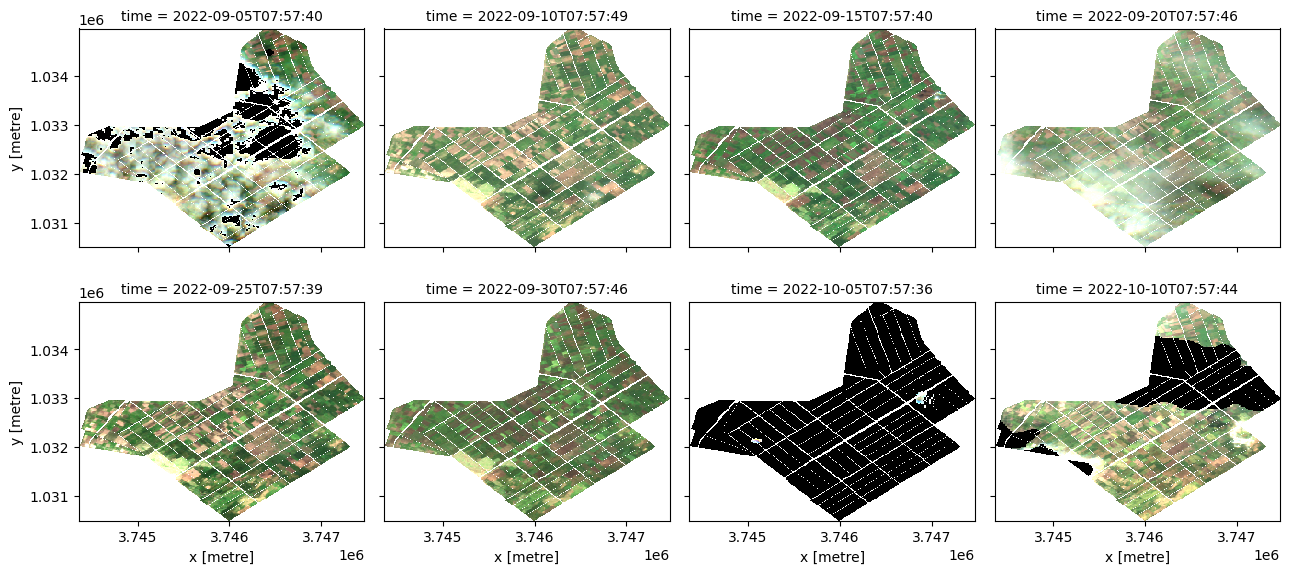

In [19]:
rgb(ds.isel(time=slice(0,8)), bands=['red', 'green', 'blue'], col="time", col_wrap=4, size=3)

### Plot a single band and three band time series animated GIF

The `xr_animation()` function within `matplotlib.animation` shows changes in the landscape across time though animation of an `xarray.Dataset` in a one band or three band (e.g. true or false colour) GIF or MP4 file format.

* `.gif`: is an ideal file format for sharing in all versions of Powerpoint, WhatsApp, Telegram group and Twitter.

In the following exercise, you will plot the dataset you loaded above as an animated GIF, using the ` ['red', 'green', 'blue'] ` satellite bands to generate a true-colored RGB animation. Set the animation time frames to 700 milliseconds using `interval`, and the animation's width is set to 350 pixels using `width pixels`.

If these parameters are not specified, the function will use a default `interval` value of 100 milliseconds and a default `width_pixels` value of 500 pixels.



In [20]:
import matplotlib.patheffects as PathEffects
from skimage.exposure import rescale_intensity
from matplotlib.animation import FuncAnimation
from tqdm.auto import tqdm
from pathlib import Path

def xr_animation(
    ds,
    bands=None,
    output_path="animation.mp4",
    width_pixels=500,
    interval=100,
    percentile_stretch=(0.02, 0.98),
    image_proc_funcs=None,
    show_gdf=None,
    show_date="%d %b %Y",
    show_text=None,
    show_colorbar=True,
    gdf_kwargs={},
    annotation_kwargs={},
    imshow_kwargs={},
    colorbar_kwargs={},
    limit=None,
):


    def _start_end_times(gdf, ds):
        """
        Converts 'start_time' and 'end_time' columns in a
        `geopandas.GeoDataFrame` to datetime objects to allow vector
        features to be plotted at specific moments in time during an
        animation, and sets default values based on the first
        and last time in `ds` if this information is missing from the
        dataset.
        """

        # Make copy of gdf so we do not modify original data
        gdf = gdf.copy()

        # Get min and max times from input dataset
        minmax_times = pd.to_datetime(ds.time.isel(time=[0, -1]).values)

        # Update both `start_time` and `end_time` columns
        for time_col, time_val in zip(["start_time", "end_time"], minmax_times):

            # Add time_col if it does not exist
            if time_col not in gdf:
                gdf[time_col] = np.nan

            # Convert values to datetimes and fill gaps with relevant time value
            gdf[time_col] = pd.to_datetime(gdf[time_col], errors="ignore")
            gdf[time_col] = gdf[time_col].fillna(time_val)

        return gdf

    def _add_colorbar(fig, ax, vmin, vmax, imshow_defaults, colorbar_defaults):
        """
        Adds a new colorbar axis to the animation with custom minimum
        and maximum values and styling.
        """

        # Create new axis object for colorbar
        cax = fig.add_axes([0.02, 0.02, 0.96, 0.03])

        # Initialise color bar using plot min and max values
        img = ax.imshow(np.array([[vmin, vmax]]), **imshow_defaults)
        fig.colorbar(img, cax=cax, orientation="horizontal", ticks=np.linspace(vmin, vmax, 2))

        # Fine-tune appearance of colorbar
        cax.xaxis.set_ticks_position("top")
        cax.tick_params(axis="x", **colorbar_defaults)
        cax.get_xticklabels()[0].set_horizontalalignment("left")
        cax.get_xticklabels()[-1].set_horizontalalignment("right")

    def _frame_annotation(times, show_date, show_text):
        """
        Creates a custom annotation for the top-right of the animation
        by converting a `xarray.DataArray` of times into strings, and
        combining this with a custom text annotation. Handles cases
        where `show_date=False/None`, `show_text=False/None`, or where
        `show_text` is a list of strings.
        """

        # Test if show_text is supplied as a list
        is_sequence = isinstance(show_text, (list, tuple, np.ndarray))

        # Raise exception if it is shorter than number of dates
        if is_sequence and (len(show_text) == 1):
            show_text, is_sequence = show_text[0], False
        elif is_sequence and (len(show_text) < len(times)):
            raise ValueError(
                f"Annotations supplied via `show_text` must have "
                f"either a length of 1, or a length >= the number "
                f"of timesteps in `ds` (n={len(times)})"
            )

        times_list = times.dt.strftime(show_date).values if show_date else [None] * len(times)
        text_list = show_text if is_sequence else [show_text] * len(times)
        annotation_list = [
            "\n".join([str(i) for i in (a, b) if i]) for a, b in zip(times_list, text_list)
        ]

        return annotation_list

    def _update_frames(
        i,
        ax,
        extent,
        annotation_text,
        gdf,
        gdf_defaults,
        annotation_defaults,
        imshow_defaults,
    ):
        """
        Animation called by `matplotlib.animation.FuncAnimation` to
        animate each frame in the animation. Plots array and any text
        annotations, as well as a temporal subset of `gdf` data based
        on the times specified in 'start_time' and 'end_time' columns.
        """

        # Clear previous frame to optimise render speed and plot imagery
        ax.clear()
        ax.imshow(
            array[i, ...].clip(0.0, 1.0),
            extent=extent,
            vmin=0.0,
            vmax=1.0,
            **imshow_defaults,
        )

        # Add annotation text
        ax.annotate(annotation_text[i], **annotation_defaults)

        # Add geodataframe annotation
        if show_gdf is not None:

            # Obtain start and end times to filter geodataframe features
            time_i = ds.time.isel(time=i).values

            # Subset geodataframe using start and end dates
            gdf_subset = show_gdf.loc[
                (show_gdf.start_time <= time_i) & (show_gdf.end_time >= time_i)
            ]

            if len(gdf_subset.index) > 0:

                # Set color to geodataframe field if supplied
                if ("color" in gdf_subset) and ("color" not in gdf_kwargs):
                    gdf_defaults.update({"color": gdf_subset["color"].tolist()})

                gdf_subset.plot(ax=ax, **gdf_defaults)

        # Remove axes to show imagery only
        ax.axis("off")

        # Update progress bar
        progress_bar.update(1)

    # Test if bands have been supplied, or convert to list to allow
    # iteration if a single band is provided as a string
    if bands is None:
        raise ValueError(
            f"Please use the `bands` parameter to supply "
            f"a list of one or three bands that exist as "
            f"variables in `ds`, e.g. {list(ds.data_vars)}"
        )
    elif isinstance(bands, str):
        bands = [bands]

    # Test if bands exist in dataset
    missing_bands = [b for b in bands if b not in ds.data_vars]
    if missing_bands:
        raise ValueError(
            f"Band(s) {missing_bands} do not exist as " f"variables in `ds` {list(ds.data_vars)}"
        )

    # Test if time dimension exists in dataset
    if "time" not in ds.dims:
        raise ValueError(
            "`ds` does not contain a 'time' dimension required for generating an animation"
        )

    # Set default parameters
    outline = [PathEffects.withStroke(linewidth=2.5, foreground="black")]
    annotation_defaults = {
        "xy": (1, 1),
        "xycoords": "axes fraction",
        "xytext": (-5, -5),
        "textcoords": "offset points",
        "horizontalalignment": "right",
        "verticalalignment": "top",
        "fontsize": 20,
        "color": "white",
        "path_effects": outline,
    }
    imshow_defaults = {"cmap": "magma", "interpolation": "nearest"}
    colorbar_defaults = {"colors": "white", "labelsize": 12, "length": 0}
    gdf_defaults = {"linewidth": 1.5}

    # Update defaults with kwargs
    annotation_defaults.update(annotation_kwargs)
    imshow_defaults.update(imshow_kwargs)
    colorbar_defaults.update(colorbar_kwargs)
    gdf_defaults.update(gdf_kwargs)

    # Get info on dataset dimensions
    height, width = ds.geobox.shape
    scale = width_pixels / width
    left, bottom, right, top = ds.geobox.extent.boundingbox

    # Prepare annotations
    annotation_list = _frame_annotation(ds.time, show_date, show_text)

    # Prepare geodataframe
    if show_gdf is not None:
        show_gdf = show_gdf.to_crs(ds.geobox.crs)
        show_gdf = gpd.clip(show_gdf, mask=box(left, bottom, right, top))
        show_gdf = _start_end_times(show_gdf, ds)

    # Convert data to 4D numpy array of shape [time, y, x, bands]
    ds = ds[bands].to_array().transpose(..., "variable")[0:limit, ...]
    array = ds.astype(np.float32).values

    # Optionally apply image processing along axis 0 (e.g. to each timestep)
    bar_format = (
        "{l_bar}{bar}| {n_fmt}/{total_fmt} ({remaining_s:.1f} "
        "seconds remaining at {rate_fmt}{postfix})"
    )
    if image_proc_funcs:
        print("Applying custom image processing functions")
        for i, array_i in tqdm(
            enumerate(array),
            total=len(ds.time),
            leave=False,
            bar_format=bar_format,
            unit=" frames",
        ):
            for func in image_proc_funcs:
                array_i = func(array_i)
            array[i, ...] = array_i

    # Clip to percentiles and rescale between 0.0 and 1.0 for plotting
    vmin, vmax = np.quantile(array[np.isfinite(array)], q=percentile_stretch)

    # Replace with vmin and vmax if present in `imshow_defaults`
    if "vmin" in imshow_defaults:
        vmin = imshow_defaults.pop("vmin")
    if "vmax" in imshow_defaults:
        vmax = imshow_defaults.pop("vmax")

    # Rescale between 0 and 1
    array = rescale_intensity(array, in_range=(vmin, vmax), out_range=(0.0, 1.0))
    array = np.squeeze(array)  # remove final axis if only one band

    # Set up figure
    fig, ax = plt.subplots()
    fig.set_size_inches(width * scale / 72, height * scale / 72, forward=True)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

    # Optionally add colorbar
    if show_colorbar & (len(bands) == 1):
        _add_colorbar(fig, ax, vmin, vmax, imshow_defaults, colorbar_defaults)

    # Animate
    print(f"Exporting animation to {output_path}")
    anim = FuncAnimation(
        fig=fig,
        func=_update_frames,
        fargs=(
            ax,  # axis to plot into
            [left, right, bottom, top],  # imshow extent
            annotation_list,  # list of text annotations
            show_gdf,  # geodataframe to plot over imagery
            gdf_defaults,  # any kwargs used to plot gdf
            annotation_defaults,  # kwargs for annotations
            imshow_defaults,
        ),  # kwargs for imshow
        frames=len(ds.time),
        interval=interval,
        repeat=False,
    )

    # Set up progress bar
    progress_bar = tqdm(total=len(ds.time), unit=" frames", bar_format=bar_format)

    # Export animation to file
    if Path(output_path).suffix == ".gif":
        anim.save(output_path, writer="pillow")
    else:
        anim.save(output_path, dpi=72)

    # Update progress bar to fix progress bar moving past end
    if progress_bar.n != len(ds.time):
        progress_bar.n = len(ds.time)
        progress_bar.last_print_n = len(ds.time)

In [21]:
# Produce time series animation of red, green and blue bands
#xr_animation(ds=ds,
#             bands=['red', 'green', 'blue'],
#             output_path='Analyse_multiple_polygons.gif',
#             interval=700,
#             width_pixels=325,
#             annotation_kwargs={'fontsize': 10})
# Plot animated gif
#plt.close()
#Image(filename='Analyse_multiple_polygons.gif')

### Plotting single band animations
It is also possible to create a single-band time series image animation rather than a three-band image animation. For this exercise use the Normalized Difference Moisture Index (NDMI) to plot a single-band animation.  

By default the colour bar limits are set based on `percentile_stretch` which will discard outliers/extreme values to optimise the colour stretch (set `percentile_stretch=(0.0, 1.00)` to show the full range of values from min to max).

In [22]:
ds['NDMI'] = ((ds.nir - ds.swir_1) /
              (ds.nir + ds.swir_1))

# Produce time series animation of NDWI:
#xr_animation(ds=ds,
#             output_path='Analyse_multiple_polygons.gif',
#             bands=['NDMI'],
#             show_text='NDMI',
#             interval=700,
#             width_pixels=325,
#             imshow_kwargs={'cmap': 'RdYlGn', 'vmin': -0.6, 'vmax': 0.8},
#             colorbar_kwargs={'colors': 'black'},
#             annotation_kwargs={'fontsize': 10})
#percentile_stretch=(0, 0)
#Plot animated gif
#plt.close()
#Image(filename='Analyse_multiple_polygons.gif')

Here we create a new variable (```resample_sentinel_2_ds```) which describes a grouping of the data we previously loaded (```sentinel_2_ds```), divided into 1-month intervals.

In [23]:
resample_sentinel_2_ds = ds.resample(time='ME').median()

Use the following code to plot the geomedian_resample dataset.

In [24]:
#rgb(resample_sentinel_2_ds, bands=['red', 'green', 'blue'], col="time", col_wrap=4, size=3)

### Soil moisture distribution in an irrigation scheme

The `NDMI` leverages the NIR and SWIR_1 spectral bands to measure canopy soil moisture pixel-by-pixel. The `NIR (Near-Infrared)` band is highly sensitive to water content in plant tissues, whereas `SWIR-1 (Shortwave Infrared-1)` band is highly sensitive to soil moisture content, particularly in the top layer.
Combining the NIR and SWIR-1 spectral bands allows for the detection of changes in leaf water potential, which is often correlated with soil moisture. Here's the NDMI formula:

$$
\begin{aligned}
\text{NDMI} & = \frac{(\text{NIR} - \text{SWIR_1})}{(\text{NIR} + \text{SWIR_2})} \\
\end{aligned}
$$

* High NDMI values: indicates high vegetation moisture content.
* Low NDMI values: indicates low vegetation moisture content or `potential moisture stress`.
* Negative NDMI values: indicates bare soil or non-vegetated areas.

Next, create a new cell and run the code below to generate NDMI maps for each geomedian. Create variables `nir` and `swir_1` and set them to equal `geomedian_resample.nir` and `geomedian_resample.swir_1` respectively.

In [25]:
## this is not needed as NDMI is already calculated above in the geomedian
swir_1 = resample_sentinel_2_ds.swir_1
nir = resample_sentinel_2_ds.nir

NDMI= (nir - swir_1) / (nir + swir_1)

### Plot NDMI for each geomedian

Then call the `plot` function to plot the NDMI data, at monthly interval. This allows you to visualize the soil moisture distribution at each irrigation block.

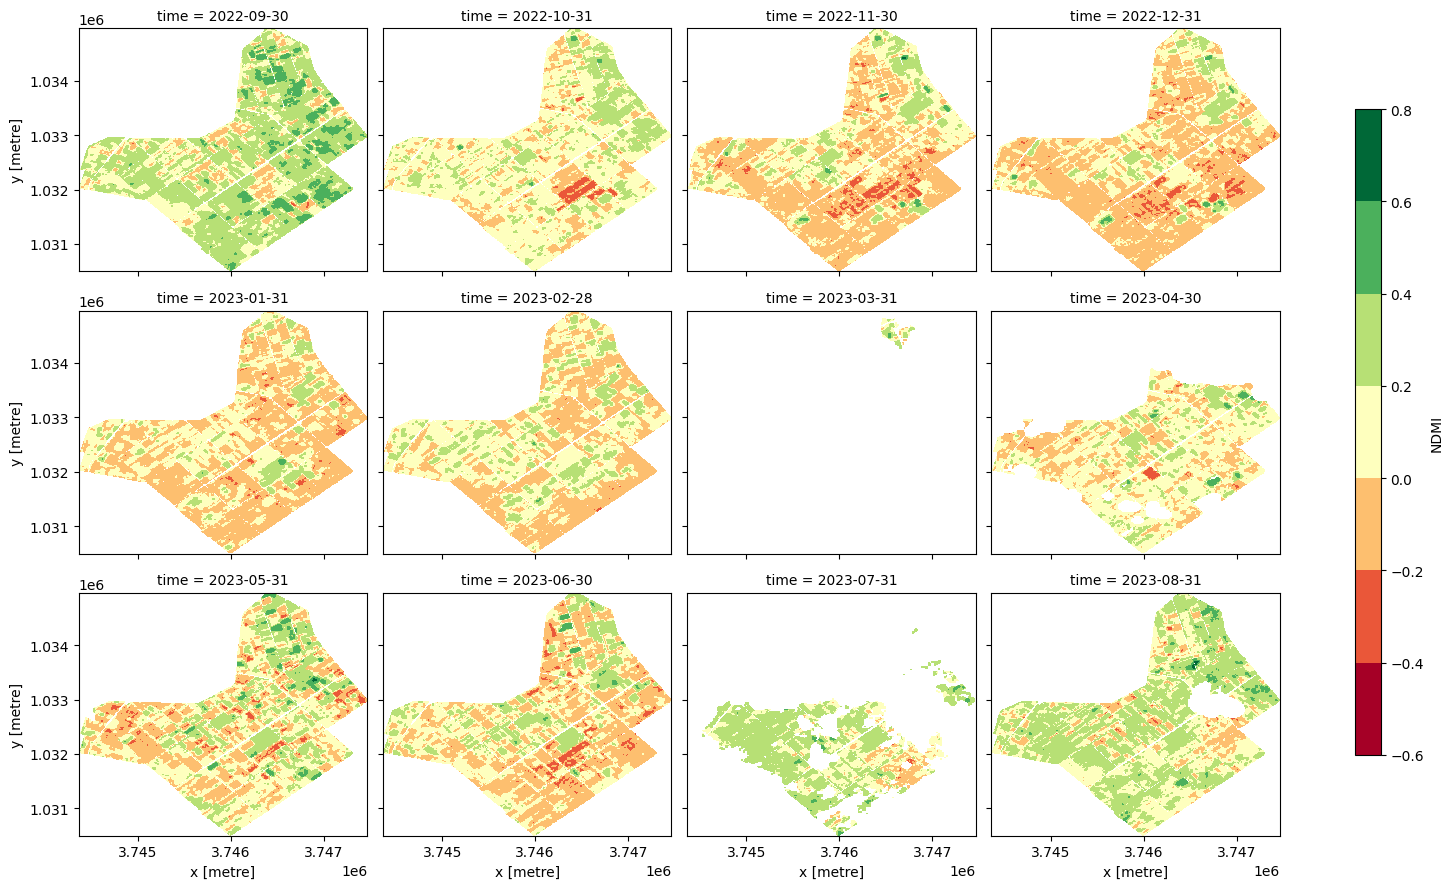

In [26]:
#creat a dictionary of arrangements and values
map_query = dict(size=3,
                aspect=1.25,
                col='time',
                cmap='RdYlGn',
                col_wrap=4,
                levels=[-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,],
                #add colorbar=True,
                cbar_kwargs=dict(label='NDMI',
                location= 'right',
                shrink=0.8,
                aspect=25))
#create plot object
ndmi= NDMI.plot.contourf(**map_query)

However, the `SWIR-1` is affected by vegetation density. As a result, the shortwave infrared-2 (`SWIR-2`) spectral band can be applied to study soil moisture in areas with dense vegetation cover. The `LSWI` uses the SWIR_2 and NIR spectral bands to map the spatial distribution of soil moisture. Here's the LSWI formula:

$$
\begin{aligned}
\text{LSWI} & = \frac{(\text{NIR} - \text{SWIR_2})}{(\text{NIR} + \text{SWIR_2})} \\
\end{aligned}
$$

Use the following code to calculate the LSWI. Create variables ``nir`` and ``swir_2`` to store ``geomedian_resample.nir`` and ``geomedian_resample.swir_2`` respectively.

In [27]:
swir_2 = resample_sentinel_2_ds.swir_2
nir = resample_sentinel_2_ds.nir

NDMI_1 = (nir - swir_2) / (nir + swir_2)

### Plot LSWI for each geomedian
Here call the `plot` function to plot `LSWI` data, at monthly interval.

In [28]:
#creat a dictionary of arrangements and values
#map_query = dict(size=2.5,
#                aspect=1.25,
#                col='time',
#                cmap='RdYlGn',
#                col_wrap=4,
#                levels=[-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1],
#                #add colorbar=True,
#                cbar_kwargs=dict(label='NDMI',
#                location= 'right',
#                shrink=0.8,
#                aspect=25))
#create plot object
#lswi= NDMI_1.plot.contourf(**map_query)

### Plot the moisture index over time

To study the soil moisture temporal varation, plot a zonal time series over the region of interest.   

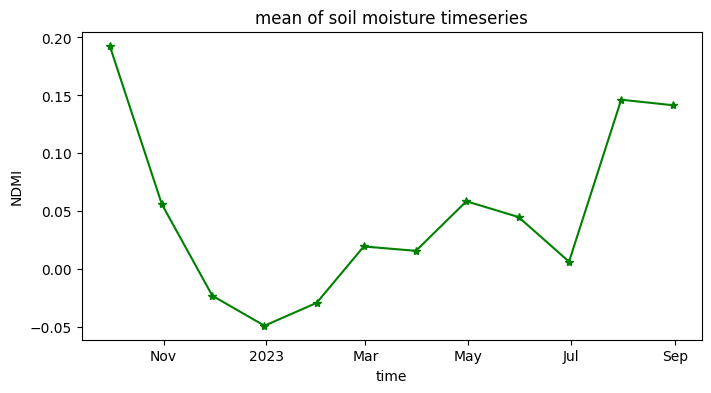

In [29]:
resample_sentinel_2_ds.NDMI.mean(['x', 'y']).plot.line('g-*', figsize=(8, 4))
plt.title('mean of soil moisture timeseries');

### Spatiotemporal soil moisture distributions at the Meki-Ziway irrigation scheme

The `mean`, `median`, `standard deviation` and `coefficient of variation (CV)` are common statistical measures used to assess soil moisture variability over time and space.

The `mean` represents the `average moisture` values across a region.

The `median` provides a more robust measure of `central tendency`, and less influenced by outliers.

The `Standard deviation` measures the `dispersion moisture` values around the mean.

To do this, create a new cell and run the following code:

In [30]:
# Calculate mean, median, and standard deviation
mean_NDMI = NDMI.mean(dim='time')
median_NDMI = NDMI.median(dim='time')
std_NDMI = NDMI.std(dim='time')

# Convert to numpy arrays for further processing or visualization
mean_NDMI_array = mean_NDMI.values
median_NDMI_array = median_NDMI.values
std_NDMI_array = std_NDMI.values

Use the following code to create the spatial distribution of `mean` and `median` soil moisture in the study region.  

In [ ]:
mean_NDMI.plot(figsize=(5,3), vmin=-0.6, vmax=0.6, cmap='RdYlGn',col_wrap=3)
plt.title('Mean of NDMI')
median_NDMI.plot(figsize=(5,3), vmin=-0.6, vmax=0.6, cmap='RdYlGn',col_wrap=3)
plt.title('Median of NDMI')

The coefficient of variation expresses the relative variability of soil moisture as a percentage of the mean, providing a standardized measure of dispersion. Use the following code to create the coefficient of variation.

In [ ]:
# Calculate coefficient of variation
cv_NDMI = std_NDMI / mean_NDMI
cv_NDMI_array = cv_NDMI.values

### Plote the coefficient of varation

In [ ]:
cv_NDMI.plot(figsize=(7,5), vmin=0.0, vmax=1.0, cmap='RdYlGn')
plt.title('Coefficient of varation of NDMI')

A high `coefficient of variation` within a region indicates significant spatial variability in soil moisture, indicating water stress in that area.   

### Soil moisture statistics for each irrigation blocks

In [ ]:
#create empty dataframe to store monthly statistics
monthly_stats = xr.Dataset()

In [ ]:
# rasterise the vector dataset
rasterized_zones = xr_rasterize(gdf, ds, attribute_col ='ID')

In [ ]:
# Loop throuth each month and calculate NDMI statistics
month_dict = []
for month in geomedian_resample.time.values:
    # Calculate NDMI
    NDMI= (nir.sel(time=month)-swir_1.sel(time=month)) / (nir.sel(time=month)+swir_1.sel(time=month))
    # Calculate zonal statistics for each irrigation blocks
    block_ndmi = zonal_stats(rasterized_zones, NDMI)
    block_ndmi['month'] = month
    month_dict.append(block_ndmi)
block_ndmi = pd.concat(month_dict)

In [ ]:
#save the monthly statistics to a CSV file
block_ndmi.to_csv('monthly_ndmi_stats.csv')